In this notebook, we will recreate the results presented in O'Malley et al.'s _Scalable Quantum Simulation of Molecular Energies_ ([arXiv:1512.06860](https://arxiv.org/abs/1512.06860)) using pyQuil. This notebook will demonstrate how to

- prepare the ansatz presented in the paper
- calculate the expectation values of the Pauli operators and weighted Hamiltonian in the paper
- simulate a VQE experiment

all using pyQuil.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.paulis import sI, sX, sY, sZ, PauliTerm

wfs = WavefunctionSimulator()

First, we'll create a pyQuil `Program` object to prepare the ansatz presented in Figure 1 of O'Malley et al., $\psi(\theta)$.

![Figure 1 - ansatz preparation and weighted Hamiltonian](vqe_fig1.png)

Note how we declare a real placeholder `THETA` to be specified later, thereby leveraging pyQuil 2.x's parametric program capability.

In [2]:
def build_program_wo_ro_measure():
    program = Program("""
# declare placeholder for continuously parameterized RZ rotation angle
DECLARE theta REAL

# set up initial state
X 0

# build the exponentiated operator
RX(-pi/2) 0
RY(pi/2) 1

CNOT 1 0
RZ(theta) 0
CNOT 1 0

RX(pi/2) 0
RY(-pi/2) 1""")
    return program

program_wo_ro_measure = build_program_wo_ro_measure()
print(program_wo_ro_measure)

DECLARE theta REAL[1]
X 0
RX(-pi/2) 0
RY(pi/2) 1
CNOT 1 0
RZ(theta[0]) 0
CNOT 1 0
RX(pi/2) 0
RY(-pi/2) 1



Now, we'll list the Pauli terms in the weighted Hamiltonian. Recall from O'Malley et al. that the weights $g_i$ are a function of the bond length $R$, i.e. $g_i = g_i(R)$. We'll dot this list with the coefficients vector once we know which bond length we're dealing with.

In [3]:
pauli_terms = [sI(0)*sI(1), sZ(0)*sI(1), sI(0)*sZ(1), sZ(0)*sZ(1), sY(0)*sY(1), sX(0)*sX(1)]

for term in pauli_terms:
    print(term.pauli_string())


Z
Z
ZZ
YY
XX


## calculating Pauli expectation values - recreating Figure 2a

Now we can calculate the expectation value of our ansatz for each Pauli term in the list above. These expectation values are plotted as a function of $\theta$, the sole parameter in the parameterized circuit prepared above, e.g. $\left<XX\right>(\theta) = \left<\psi(\theta)|XX|\psi(\theta)\right>$.

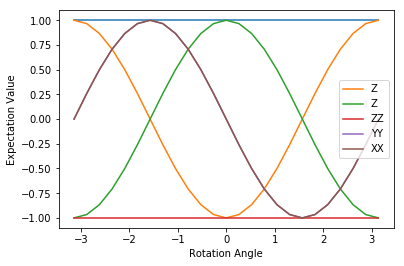

In [4]:
thetas = np.linspace(-np.pi, np.pi, 25)

pauli_term_evs = [[]]*len(pauli_terms)
for theta in thetas:
    pauli_term_expectation_values = wfs.expectation(program_wo_ro_measure,
                                                    pauli_terms,
                                                    memory_map={'theta': [theta]})
    pauli_term_evs = list(map(lambda x,y: x + [y], pauli_term_evs, pauli_term_expectation_values))

for i in range(len(pauli_terms)):
    plt.plot(thetas, pauli_term_evs[i], label=pauli_terms[i].pauli_string())
    plt.xlabel('Rotation Angle')
    plt.ylabel('Expectation Value')
    plt.legend()

## simulating the energy surface as a function of $\theta$ and $R$ - recreating Figure 2b

Now we can simulate the two-dimensional energy surface as a function of the parameter passed to our parameterized circuit, $\theta$, and the bond length, $R$. To calculate the expectation value of the Hamiltonian, we simply have to dot the Hamiltonian weights vector, which is a function of bond length, with the vector of expectation values for the Pauli terms comprising the Hamiltonian, which is a function of $\theta$. We do this for every pair of $R$ and $\theta$ values we with to sample and plot the two-dimensional energy surface.

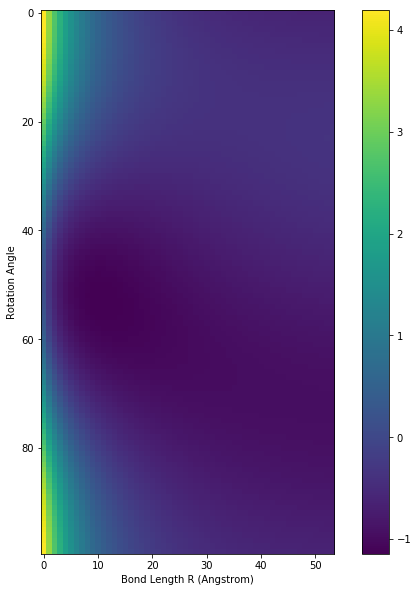

In [5]:
thetas = np.linspace(-np.pi, np.pi, 100)
bond_lengths = np.linspace(0.20, 2.85, 54) # values determined by Hamiltonian coefficients in Table 1

hamiltonain_coefficients = pd.read_csv('vqe_h2.csv', index_col=0, header=None)

hamiltonian_evs = np.zeros((len(thetas), len(bond_lengths)))
for i, theta in enumerate(thetas):
    pauli_term_expectation_values = wfs.expectation(program_wo_ro_measure,
                                                    pauli_terms,
                                                    memory_map={'theta': [theta]})
    for j, R in enumerate(bond_lengths):
        hamiltonian_weights = list(hamiltonain_coefficients.loc[round(R, 2)])
        # dot the Pauli term expectation values vector with the Hamiltonian weights vector, which is a 
        # function of bond length R
        hamiltonian_expectation_value = np.dot(pauli_term_expectation_values, hamiltonian_weights)
        hamiltonian_evs[i][j] = hamiltonian_expectation_value
        
plt.figure(figsize=(10,10))
plt.imshow(hamiltonian_evs)
plt.colorbar()
plt.xlabel('Bond Length R (Angstrom)')
plt.ylabel('Rotation Angle')
plt.show()

## simulating the $H_2$ energy curve - recreating Figure 3a

At each bond length $R$, we can find the $\theta$ that minimizes the expectation value of the Hamiltonian $\left<H\right>$. We can then plot this minimum $\left<H\right>$ as a function of $R$ to find the energy curve for $H_2$.

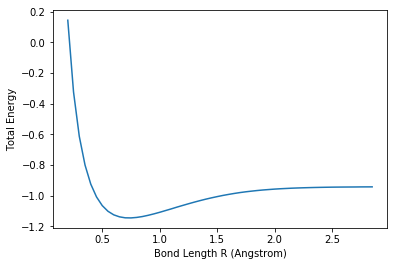

In [6]:
min_energies = []
for col in range(hamiltonian_evs.shape[1]):
    energies = list(hamiltonian_evs[:,col])
    min_energy = min(energies)
    min_energies.append(min_energy)
    theta_min_ev = energies.index(min(energies))
    
plt.plot(bond_lengths, min_energies)
plt.xlabel('Bond Length R (Angstrom)')
plt.ylabel('Total Energy')
plt.show()

Note that we could have arrived at the minimum energy more quickly using a classical optimizer than calculating all the values sampled in an interval and picking out the smallest value.